# Predicting Fraudulent Credit Card Transaction with NN

Inspiration  
Identify fraudulent credit card transactions.  
https://www.kaggle.com/mlg-ulb/creditcardfraud/home


In [49]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier



### 0. Load and explore data

#### Data Description 

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [19]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Features

Based on data description, we know that v1-v28 are PCA components, they are all numerical variables, so we do not have categorical variables to encode. And here we are going to build a NN, we do not need take care of feature correlation problem (ref). But, NN is very sensitive to feature scaling, here we need normalize the Amount.

In [20]:
data['Normalized_Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Time','Amount'],axis=1)

### Class imbalance

As pointed out, the data is highly unbalanced, with only 492 frauds out of 284,807 transactions. 

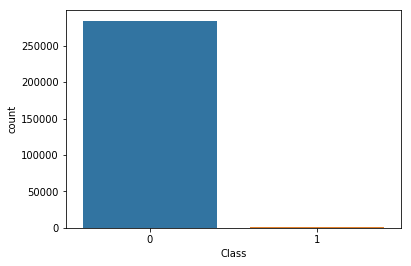

In [21]:
sns.countplot("Class",data=data)

## 1. Define model performance

For such unbalanced classification problem, we need define a proper metric. In this case, we want to detect as many frauds as possible, because for a bank, the cost of identifying a fraud as a normal transaction is very expensive. Therefore, we want use recall, precision or ROUARU intead of accuracy. 

Confusion matrix : also known as the error matrix, allows visualization of the performance of an algorithm :  

true positive (TP) : Diabetic correctly identified as diabetic  
true negative (TN) : Healthy correctly identified as healthy  
false positive (FP) : Healthy incorrectly identified as diabetic  
false negative (FN) : Diabetic incorrectly identified as healthy  

Metrics :  

Accuracy : (TP +TN) / (TP + TN + FP +FN)  
Precision : TP / (TP + FP)  
Recall : TP / (TP + FN)  
F1 score : 2 x ((Precision x Recall) / (Precision + Recall))  

Roc Curve :   

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.



In [22]:
def model_performance(y_test, y_pred) :
    
     # Confusion matrix
    CM = confusion_matrix(y_test, y_pred)
    # Get true positives(tp), false positives(fp), false negatives(fn)
    tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

    # Prediction report
    sns.heatmap(CM,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(y_test.values, y_pred))

## 2. Split the data

A common solution for imbalanced classification problem is under sampling or over sampling. Here I tested under sampling, to make the algorithm run faster too. Basically, I choose equall amount of normal transactions as the fraud transactions. 

In [23]:
number_of_fraud = len(data[data.Class == 1])
number_of_normal= len(data[data.Class == 0])

#indices of normal class
indices_of_normal = data[data.Class==0].index
#randomly choose same amount of samples as the fraud, and return their indices
random_indices_of_normal = np.array(np.random.choice(indices_of_normal, number_of_fraud, replace=False))
#indices of fraud class
indices_of_fraud = np.array(data[data.Class == 1].index)
#indices of undersampled dataset
indices_of_undersampled = np.concatenate([random_indices_of_normal, indices_of_fraud])
#undersampled dataset)
data_of_undersampled = data.iloc[indices_of_undersampled,:]

#undersampled dataset
X_undersampled = data_of_undersampled.loc[:,data_of_undersampled.columns!='Class']
y_undersampled = data_of_undersampled.loc[:,data_of_undersampled.columns=='Class']

#train and test dataset splitted from undersampled dataset, with 70/30 ratio
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled,y_undersampled,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train_undersampled))
print("Number transactions test dataset: ", len(X_test_undersampled))

Number transactions train dataset:  688
Number transactions test dataset:  296


## 3. Creat model

In [30]:
def create_model(optimizer='rmsprop',neuron1=1,neuron2=1):
    
    # Start neural network
    model = Sequential()

    # Add fully connected layer with a ReLU activation function
    model.add(Dense(neuron1, activation='relu', input_shape=(29,)))

    # Add fully connected layer with a ReLU activation function
    model.add(Dense(neuron2, activation='relu'))

    # Add fully connected layer with a sigmoid activation function
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile neural network
    model.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer=optimizer, # Optimizer
                    metrics=['accuracy']) # Accuracy performance metric
    
    # Return compiled network
    return model

In [31]:
# Wrap Keras model so it can be used by scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=0)

## 4. Hyperparameter tunning with GridSearch

Create Hyperparameter Search Space

In [37]:
# Create hyperparameter space
neuron1 = [1, 3, 5, 7]
neuron2=[1,2,3]
epochs = [5, 10]
batches = [5, 10, 100]
optimizers = ['rmsprop', 'adam']

# Create hyperparameter options
hyperparameters = dict(neuron1=neuron1, neuron2=neuron2, optimizer=optimizers, epochs=epochs, batch_size=batches)
#hyperparameters = dict(neuron1=neuron1, neuron2=neuron2)

Conduct Grid Search

In [38]:
# Create grid search
grid = GridSearchCV(estimator=model, param_grid=hyperparameters, n_jobs=-1)

# Fit grid search
grid_result = grid.fit(X_train_undersampled, y_train_undersampled)

C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs 

C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs 

In [39]:
grid_result.best_params_

{'batch_size': 5,
 'epochs': 10,
 'neuron1': 5,
 'neuron2': 3,
 'optimizer': 'rmsprop'}

## 5. Predict

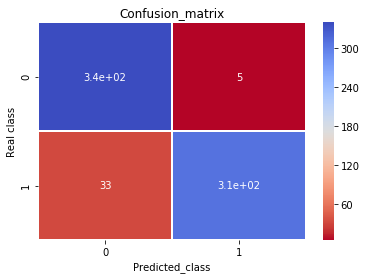


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       345
           1       0.98      0.90      0.94       343

   micro avg       0.94      0.94      0.94       688
   macro avg       0.95      0.94      0.94       688
weighted avg       0.95      0.94      0.94       688



In [50]:
y_train_predict = grid_result.predict(X_train_undersampled)
model_performance(y_train_undersampled, y_train_predict)

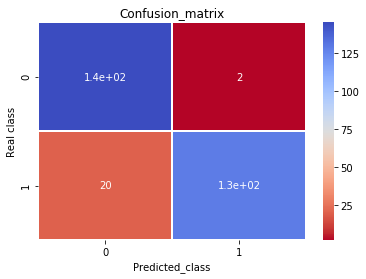


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       147
           1       0.98      0.87      0.92       149

   micro avg       0.93      0.93      0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296



In [51]:
y_test_predict = grid_result.predict(X_test_undersampled)
model_performance(y_test_undersampled, y_test_predict)

## 6. References  

https://www.kaggle.com/mlg-ulb/creditcardfraud/home  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html  
https://chrisalbon.com/deep_learning/keras/tuning_neural_network_hyperparameters/  
http://colinraffel.com/wiki/neural_network_hyperparameters  
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/  
https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a  
https://www.analyticsvidhya.com/blog/2018/11/neural-networks-hyperparameter-tuning-regularization-deeplearning/  
https://blogs.oracle.com/meena/simple-neural-network-model-using-keras-and-grid-search-hyperparameterstuning  